In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
import pybaseball

pybaseball.cache.enable()

In [4]:
data = pybaseball.statcast(start_dt = "2019-06-13", end_dt = "2025-05-05")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████| 1273/1273 [03:06<00:00,  6.82it/s]
c:\Users\eSports\AppData\Local\Programs\Python\Python312\Lib\site-packages\pybaseball\statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


In [5]:
filtered_data = data[["pitcher","batter","description","zone","p_throws","launch_speed","launch_angle","release_spin_rate","release_speed","release_pos_x","release_pos_z"]]

In [6]:
filtered_data = filtered_data.fillna(0)
filtered_data.head()

,pitcher,batter,description,zone,p_throws,launch_speed,launch_angle,release_spin_rate,release_speed,release_pos_x,release_pos_z
1465,660853,668715,hit_into_play,6,R,77.7,4,2116,88.1,-2.22,5.49
1486,660853,668715,ball,14,R,0.0,0,2218,97.1,-2.02,5.53
1568,660853,666158,ball,13,R,0.0,0,2212,97.0,-1.99,5.55
1583,660853,666158,foul,3,R,54.0,77,2162,96.0,-1.81,5.68
1630,660853,666158,foul,5,R,30.9,-30,1827,86.1,-1.87,5.77


In [7]:
le = LabelEncoder()
filtered_data["p_throws"] = le.fit_transform(filtered_data["p_throws"])
filtered_data["description"] = le.fit_transform(filtered_data["description"])

In [8]:
y = filtered_data[["description"]]
x = filtered_data.drop("description",axis = 1)


In [9]:
filtered_data["description"].value_counts()
print(le.inverse_transform(filtered_data["description"]))

['hit_into_play' 'ball' 'ball' ... 'hit_into_play' 'called_strike' 'ball']


<Axes: >

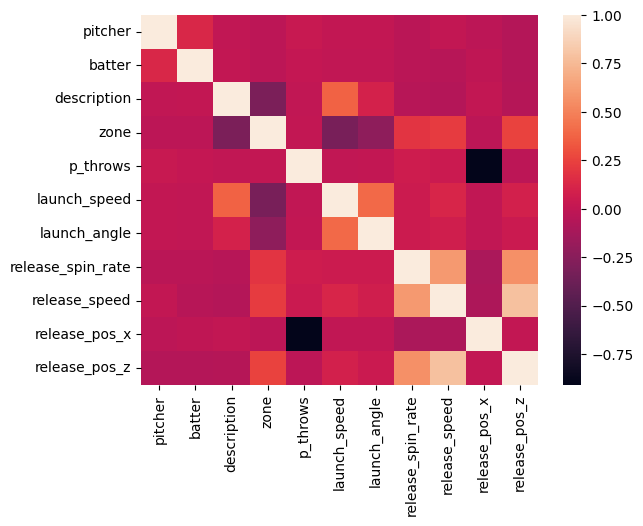

In [18]:
sns.heatmap(filtered_data.corr())

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=10)
x_test.shape
x_train.shape

(2668342, 10)

In [11]:
clf = RandomForestClassifier(verbose = 3)
clf.fit(x_train,y_train)

c:\Users\eSports\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  3.5min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

RandomForestClassifier(verbose=3)

In [12]:
y_pred = clf.predict(x_test)

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   36.1s


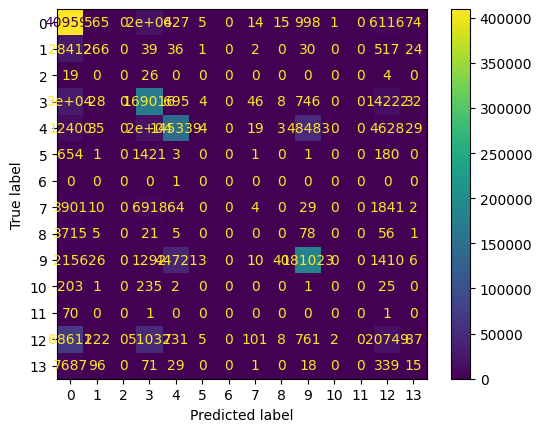

In [17]:
display_l = filtered_data["description"].values
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot()
plt.show()

In [14]:
print(f"Random Forest with full featureset accuracy score: {accuracy_score(y_test,y_pred)}")

Random Forest with full featureset accuracy score: 0.7045810605063385


In [ ]:
#Get name mappings
le_name_mapping = dict(zip(le.classes_,le.transform(le.classes_)))
print(le_name_mapping)

{'ball': 0, 'blocked_ball': 1, 'bunt_foul_tip': 2, 'called_strike': 3, 'foul': 4, 'foul_bunt': 5, 'foul_pitchout': 6, 'foul_tip': 7, 'hit_by_pitch': 8, 'hit_into_play': 9, 'intent_ball': 10, 'missed_bunt': 11, 'pitchout': 12, 'swinging_strike': 13, 'swinging_strike_blocked': 14}
